In [86]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import*

In [87]:
pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),]

In [88]:
# parameters of Hamiltonians and Lindbladians
b       = 0.1
gamma_1 = 0.02
gamma_2 = 0.05

I2 = pauli_list[0]
X = pauli_list[1]
Y = pauli_list[2]
Z = pauli_list[3]
Hamiltonian = (-b/2)*X
L_1 = np.sqrt(gamma_1)*np.matrix([[0,1],[1,0]])
L_2 = np.sqrt(gamma_2)*Z

# steady state density matrix parameters
Delta = 2*b**2+gamma_1**2+4*gamma_1*gamma_2
yss   = (2*b*gamma_1)/Delta
zss   = (gamma_1*(gamma_1+4*gamma_2))/Delta

# steady state density matrix
rho_ss = (1/2)*(I2+yss*Y+zss*Z)

# angles for steady state preparation
theta_x = np.arccos(zss)
theta_y = np.arccos(-yss/(4*np.sqrt(1+zss**2)))

## Clifford

In [94]:
# number of shadows
nShadows = 1500
# number of shots
number_of_shots = 1
# number of qubits in the system
N = 2
rng = np.random.default_rng(1717)
cliffords = [qiskit.quantum_info.random_clifford(N, seed=rng) for _ in range(nShadows)]


# setting up the quantum circuit
density_matrix_qubit = QuantumRegister(1, r"\rho_{in}")
ancilla_qubit = QuantumRegister(1, "ancilla")
qc = QuantumCircuit(density_matrix_qubit,ancilla_qubit)
# initializing the ancilla qubit at |0>.
qc.initialize([1,0],1)
qc.barrier()
qc.rx(theta_x,0)
qc.cry(theta_y,0,1)

results = []

# random unitary rotation is performed nShadows times. 
r""" 
each time the unitary rotation is perfomed on the same initial circuit. 
So the Clifford gate part is composed on the initial circuit. """
for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())
    # samples the output in computational basis.
    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(number_of_shots)
    results.append(counts)

In [96]:
#qc_c.draw("mpl",scale=2)

In [91]:
# collects the classical shadows.
shadows = []
# loops over the clifford gates and their corresponding results.
for cliff, res in zip(cliffords, results):
    # U^{\dagger} matrix.
    mat    = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        # classical shadow for Clifford = (2**N+1)*(U^{\dagger}|b><b|U-I).
        shadows.append(((2**N+1.))*np.outer(Ub,Ub.conj())*count - np.eye(2**N))

# averaging over all shadows.
rho_shadow = np.sum(shadows,axis=0)/(nShadows*number_of_shots)
# actual density matrix.
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data

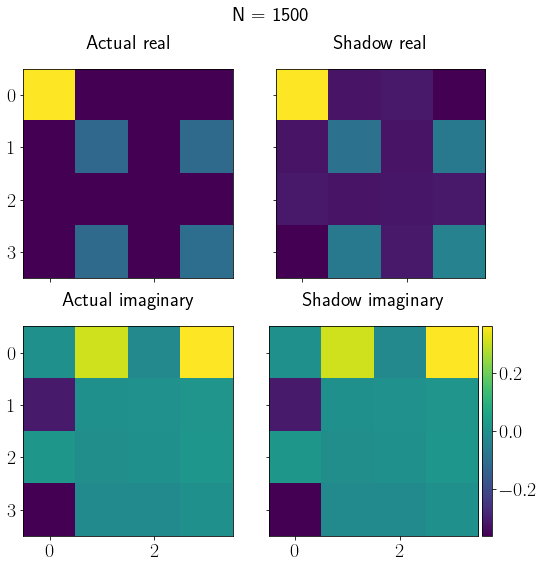

In [93]:
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
plt.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
c1 = axs[0, 0].imshow(rho_actual.real)
#fig.colorbar(c1, ax=axs[0, 0])
axs[0, 0].set_title("Actual real")
c2 = axs[0, 1].imshow(rho_shadow.real)
#fig.colorbar(c2, ax=axs[0, 1])
axs[0, 1].set_title("Shadow real")
c3 = axs[1, 0].imshow(rho_shadow.imag)
#fig.colorbar(c3, ax=axs[1, 0])
axs[1, 0].set_title("Actual imaginary")
c4 = axs[1, 1].imshow(rho_shadow.imag)
#fig.colorbar(c4, ax=axs[1,1])
axs[1, 1].set_title("Shadow imaginary")
plt.suptitle("N = "+str(nShadows))

#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(c4, cax=cax, orientation='vertical')

# Display the figure with subplots
plt.tight_layout()    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
#plt.savefig("density_matrix_comparison_"+str(nShadows)+".jpg", dpi=600)
plt.show()